In [18]:
import requests
import warnings
import math
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [19]:
def exponential_cdf(lmbda, time):
    return 1 - math.exp(-lmbda * time)

In [20]:
class FlakyClient:
    def __init__(self, base_url):
        self._base_url = base_url

    def call_status(self):
        response = requests.get(f"{self._base_url}/CircuitBreaker/Status", verify=False)
        return response.status_code, response.json()

    def call_reset(self):
        response = requests.get(f"{self._base_url}/CircuitBreaker/Reset", verify=False)
        return response.status_code

    def call_settings(self):
        response = requests.get(f"{self._base_url}/CircuitBreaker/Settings", verify=False)
        return response.status_code, response.json()

In [26]:
flaky_client = FlakyClient(base_url="https://localhost:44343")
status_code, settings = flaky_client.call_settings()
assert status_code == 200
total_requests = settings['total_time_of_interval'] * 1
time_of_first_failure = settings['time_of_first_failure']
lmbda = 1 / int(time_of_first_failure)
status_code = flaky_client.call_reset()

200 200 200 200 503 200 200 200 200 503 200 200 503 200 200 503 503 503 503 200 200 200 200 200 503 503 200 503 503 503 503 200 503 503 503 503 200 200 503 503 503 200 503 503 503 200 503 503 503 503 200 503 200 503 503 503 503 200 200 200 

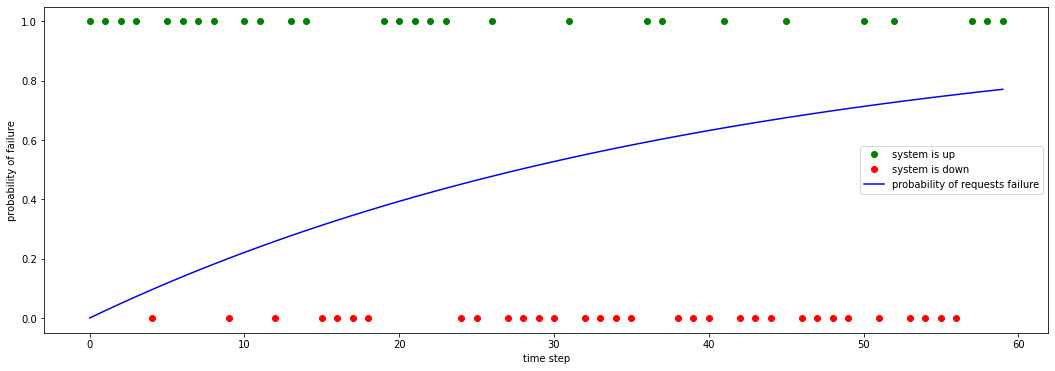

In [32]:
service_is_up = np.zeros(total_requests)
service_is_downs = np.zeros(total_requests)
failure_probability = np.zeros(total_requests)
for request_number in range(total_requests):
    failure_probability[request_number] = exponential_cdf(lmbda, request_number)
    status_code, info = flaky_client.call_status()
    print(status_code, end=' ')
    if status_code == 200:
        service_is_up[request_number] = 1
        service_is_downs[request_number] = np.nan
    else:
        service_is_up[request_number] = np.nan
        service_is_downs[request_number] = 0

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(range(total_requests), service_is_up, 'go', label='system is up')
ax.plot(range(total_requests), service_is_downs, 'ro', label='system is down')
ax.plot(range(total_requests), failure_probability, 'b', label='probability of requests failure')
ax.set_xlabel('time step')  # Add an x-label to the axes.
ax.set_ylabel('probability of failure')  # Add a y-label to the axes.
ax.legend()